# Baseline Model: Minimal Preprocessing

This notebook establishes a baseline by training a model with minimal preprocessing to compare against feature-engineered versions.


In [1]:
import numpy as np
import pandas as pd
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)
plt.style.use('seaborn-v0_8-darkgrid')


In [2]:
# Load data
with open('../adult_data.pkl', 'rb') as f:
    data = pickle.load(f)

X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

# Check target variable distribution
print(f"\nTarget variable type: {type(y_train)}")
print(f"y_train unique values: {y_train.unique()}")
print(f"y_train value counts:\n{y_train.value_counts()}")
print(f"\ny_test unique values: {y_test.unique()}")
print(f"y_test value counts:\n{y_test.value_counts()}")


Training set: (26048, 14)
Test set: (6513, 14)

Target variable type: <class 'pandas.core.series.Series'>
y_train unique values: [1 0]
y_train value counts:
0    19775
1     6273
Name: income_binary, dtype: int64

y_test unique values: [0 1]
y_test value counts:
0    4945
1    1568
Name: income_binary, dtype: int64


In [3]:
# Ensure target variable is properly formatted
# Convert to numpy array if it's a pandas Series
if hasattr(y_train, 'values'):
    y_train = y_train.values
if hasattr(y_test, 'values'):
    y_test = y_test.values

# Check if target needs to be re-encoded
unique_train = np.unique(y_train)
if len(unique_train) < 2:
    print("WARNING: y_train has only one class. Attempting to fix...")
    print(f"Current y_train unique values: {unique_train}")
    
    # Try to reload original data and recreate target
    print("\nReloading original data to recreate target variable...")
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
    columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 
               'marital-status', 'occupation', 'relationship', 'race', 'sex',
               'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
    
    df_original = pd.read_csv(url, names=columns, na_values=' ?', skipinitialspace=True)
    df_original['income_binary'] = df_original['income'].str.strip().str.contains('>50K', regex=False).astype(int)
    df_original_clean = df_original.dropna()
    
    # Recreate the split with the same random state
    from sklearn.model_selection import train_test_split
    X_original = df_original_clean.drop(['income', 'income_binary'], axis=1)
    y_original = df_original_clean['income_binary']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_original, y_original, test_size=0.2, random_state=42, stratify=y_original
    )
    
    # Convert to numpy arrays
    if hasattr(y_train, 'values'):
        y_train = y_train.values
    if hasattr(y_test, 'values'):
        y_test = y_test.values
    
    print(f"Fixed! y_train now has {len(np.unique(y_train))} classes: {np.unique(y_train)}")
    print(f"y_train distribution: {np.bincount(y_train)}")
else:
    print(f"✓ Target variable is correctly formatted with {len(unique_train)} classes: {unique_train}")


✓ Target variable is correctly formatted with 2 classes: [0 1]


## Baseline: Minimal Preprocessing

For the baseline, we'll use:
- Simple label encoding for categorical variables
- No scaling
- No feature engineering
- Basic logistic regression


In [4]:
# Separate numerical and categorical columns
numerical_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

print(f"Numerical columns: {numerical_cols}")
print(f"Categorical columns: {categorical_cols}")

# Simple label encoding for categorical variables
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X_train_encoded[col] = le.fit_transform(X_train[col].astype(str))
    X_test_encoded[col] = le.transform(X_test[col].astype(str))
    label_encoders[col] = le

print("\nBaseline preprocessing complete: Label encoding only")


Numerical columns: ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Categorical columns: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

Baseline preprocessing complete: Label encoding only


In [5]:
# Train baseline model
baseline_model = LogisticRegression(max_iter=1000, random_state=42)
baseline_model.fit(X_train_encoded, y_train)

# Predictions
y_pred_baseline = baseline_model.predict(X_test_encoded)
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)

print(f"Baseline Model Accuracy: {baseline_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_baseline))


Baseline Model Accuracy: 0.8070

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.95      0.88      4945
           1       0.69      0.36      0.47      1568

    accuracy                           0.81      6513
   macro avg       0.76      0.65      0.68      6513
weighted avg       0.79      0.81      0.78      6513



c:\Users\welcome\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


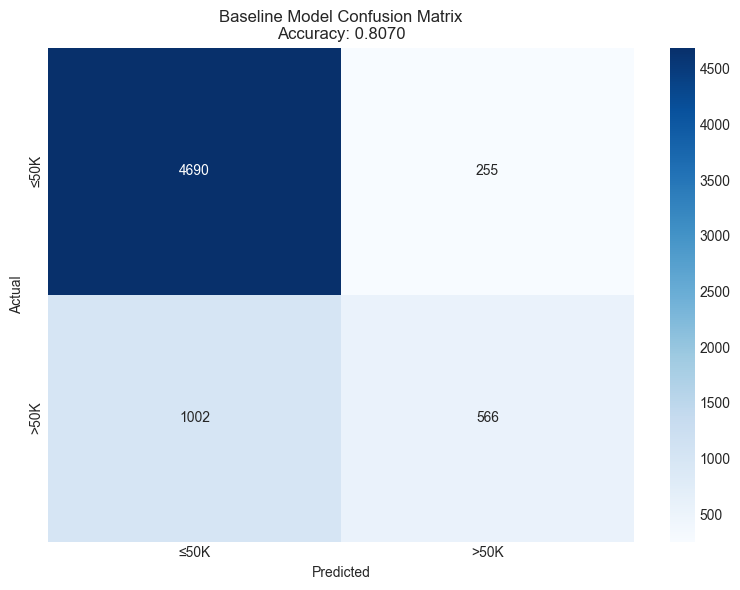

Baseline results saved to '../baseline_results.pkl'


In [6]:
# Confusion matrix
cm_baseline = confusion_matrix(y_test, y_pred_baseline)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues',
            xticklabels=['≤50K', '>50K'],
            yticklabels=['≤50K', '>50K'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Baseline Model Confusion Matrix\nAccuracy: {baseline_accuracy:.4f}')
plt.tight_layout()
plt.show()

# Save baseline results
baseline_results = {
    'accuracy': baseline_accuracy,
    'model': baseline_model,
    'label_encoders': label_encoders
}

with open('../baseline_results.pkl', 'wb') as f:
    pickle.dump(baseline_results, f)

print("Baseline results saved to '../baseline_results.pkl'")
